In [188]:
# !pip install mesa
# !apt-get install graphviz libgraphviz-dev pkg-config
# !pip install pygraphviz

### A billion import statements:

Imports of note:
+ mesa is the library I use for agent based modeling. https://mesa.readthedocs.io/en/latest/
+ numpy and pandas are used for data manipulation. https://numpy.org/ | https://pandas.pydata.org/
+ matplotlib is used for graphing. https://matplotlib.org/
+ networkx is used to create the network representation of the tree and for graphing. https://networkx.org/


In [189]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from networkx.classes.function import get_node_attributes, set_node_attributes, set_edge_attributes, get_edge_attributes
import time, enum, math
import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout, read_dot
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import itertools
import random
import json
from read_treekey import read_treekey, read_predictions

### Settings:


In [190]:
colony = False #if false, individual model. If true, colony model.


### Parameters for the model:

In [191]:
parameters = {
    'left' : 1, # left bias
    'right' : 1.074, # right bias
    'width' : 0.51, # width bias
    'u-turn' : 1, # u-turn bias

    'padd' : 0.025, # the amount of pheromone added by an ant in 1 time step (0.1)
    'pdecay' : 0.15, # this percentage of pheromone at a node is decayed each time step (.15)

    'leave_home' : 0.1 # the probability for an ant to leave their home each time step (.1)

}
other_params ={
    'treekey_file' : 'treekey.csv',
    'predictions_file' : 'NetworksSummer2021-TurnPredictions.csv',
    'color_map' : [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.14), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.4257142857142857), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.7114285714285714), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.9971428571428571), (1.0, 0.4980392156862745, 0.054901960784313725, 0.14), (1.0, 0.4980392156862745, 0.054901960784313725, 0.4257142857142857), (1.0, 0.4980392156862745, 0.054901960784313725, 0.7114285714285714), (1.0, 0.4980392156862745, 0.054901960784313725, 0.9971428571428571), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.14), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.4257142857142857), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.7114285714285714), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.9971428571428571), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.14), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.4257142857142857), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.7114285714285714), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.9971428571428571), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 0.14), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 0.4257142857142857), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 0.7114285714285714), (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 0.9971428571428571), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 0.14), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 0.4257142857142857), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 0.7114285714285714), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 0.9971428571428571), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 0.14), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 0.4257142857142857), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 0.7114285714285714), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 0.9971428571428571), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 0.14), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 0.4257142857142857), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 0.7114285714285714), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 0.9971428571428571), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (0.0, 0.0, 1.0, 1.0), (1.0, 0.0, 0.0, 1.0)]
}

In [192]:
treekey = read_treekey(file=other_params['treekey_file'])
predictions = read_predictions(file=other_params['predictions_file'])

#### 2. Construction of a balanced tree from a leaf map.
+ Given a leaf map, constructs a tree in networkx. The tree is built through joins of leaves, where a node is created to connect two leaves and its associated weight is the larger of the weights of the leaves. This process is repeated until reaching the center node.

In [193]:
def construct_tree(treekey=treekey, fooddist=['Food','Food','Nest','Node','Food','Food','Node','Nest','Node','Nest','Food','Food','Food','Food','Nest','Node','Node','Nest','Food','Food','Node','Nest','Food','Food','Nest','Node','Food','Food','Node','Nest','Food','Food']):
    """ 
    Input: a dictionary of leaf names and branch widths leading to the leaves. Leaves are named with the convention 'LRLLRL', dictating how to get to the leaf.
     + Also fooddist, a list of the tip types traveling clockwise. Used in the colony model.
    Outputs: a tree constructed in networkx following the tree building rules (joining of LR names and weights).
    """
    G = nx.read_weighted_edgelist(treekey)
    # if colony: # deoesn't currently work with colony
    #     i = 0
    #     for leaf in leafd:
    #         G.add_node(leaf, ntype = fooddist[i], ants=0) # Set leaves as a Food, Nest, or a Node
    #         i+=1
    # else:
    nx.set_node_attributes(G, False, 'nest')
    nx.set_node_attributes(G, 0, 'ants')

    leaf_list = [node for node in G.nodes() if len(list(G.neighbors(node))) <= 1] #create list of leaves

    nest_dict = dict.fromkeys(leaf_list, {'nest' : True})

    nx.set_node_attributes(G, nest_dict)

    G.remove_node('-1')
    # while not 'O' in leafd:

    #     leaf = list(leafd.keys())[0]

    #     for leaf2 in leafd:
    #         if leaf2 != leaf and len(leaf2) == len(leaf):
    #             if leaf2[:len(leaf2)-1] == leaf[:len(leaf)-1]:
    #                 junc = leaf[:len(leaf)-1] # The junction between two nodes is their name with the last letter cut off
    #                 if colony: 
    #                     if junc == 'O':
    #                         G.add_node(junc, ntype = "Home", ants=0) # Set start node as home
    #                     else:
    #                         G.add_node(junc, ntype = "Node", ants=0) # Other nodes are normal
    #                 else: 
    #                     G.add_node(junc, nest = False, ants=0)

    #                 G.add_edge(junc, leaf2, weight = leafd[leaf2], p = 0)
    #                 G.add_edge(junc, leaf, weight = leafd[leaf], p = 0)
                    
                    
    #                 leafd[junc] = (leafd[leaf] if leafd[leaf] > leafd[leaf2] else leafd[leaf2])
    #                 del leafd[leaf]
    #                 del leafd[leaf2]
    #                 break
    
    return G

# t = construct_tree()
# print(t.edges(data=True))
# print(t.nodes(data=True))

#### 3. Drawing of the network and graph following an experiment.
+ Called by experiment(), given a network, G, and the data from the experiment, constructs graph and network images.

In [194]:
def graph_draw(G,data,labels_ordered=True, show_pheromone=False,retrieve_data=False,retrieve_nest_data_only=True):
    """
    Inputs: G, a tree in networkx and data from the Mesa model. Data is in the form of dictionary with time steps. Gross conversions proceed. Labels_ordered dictacts what naming scheme to use (True = clockwise, False = lab).
    Output: draws a networkx plot and an area plot from a pandas dataframe
    """
    datan = list(G.nodes(data=True))
    nodes = G.nodes()
    

    # G = nx.relabel_nodes(G, lambda name: (int(name.replace('L','0').replace('R','1')[1:],2)+1) if len(name) == 6 else name)
    # G = nx.relabel_nodes(G, lambda name: (chr(((name-1)//4) + 65) + str((name-1)%4) if isinstance(name,int) else name)) # Changes node labels from LR to clockwise
    pos = graphviz_layout(G, prog = 'twopi') #prog = 'dot' for other view
    plt.title(str(parameters))
    
    
    colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive'] # Color set from https://www.tableau.com/new-features/10.0
    color_map = []
    shape_dict = {}
    datan = list(G.nodes(data=True)) # Load node ant pop data from tree
    i = 0
    if colony: #Colony colors:
        for node in G:
            if datan[i][1]['ntype'] == 'Nest':
                color = clr.to_rgba(colors[ord(node[0])-65]) # Nest nodes are colored based on the node name
                color_map.append(color)
                shape_dict[node] = 'p'
            elif datan[i][1]['ntype'] == "Home": # Home nest colored red
                color_map.append(clr.to_rgba('red')) 
                shape_dict[node] = 'p'
            elif datan[i][1]['ntype'] == "Food": # Food nodes are grey
                color = clr.to_rgba('grey')
                color = (color[0],color[1],color[2], color[3] - 0.5)
                color_map.append(color) 
                shape_dict[node] = '^'
            else: #Connection nodes are blue
                color = clr.to_rgba('blue') 
                color = (color[0],color[1],color[2], color[3] - 0.5)
                color_map.append(color) 
                shape_dict[node] = 'o'
            i+=1
    else: # Individual colors:
        color_map = other_params['color_map']

    
    color_map_edge = []
    weight_map = [G[u][v]['weight'] * 5 for u,v in G.edges()] # Load weight data

    if not show_pheromone:
      
      for weight in weight_map: # Color edges based on their weights
          if weight <= 0.253 * 5:
              color_map_edge += ['lightgrey']
          elif weight <= 0.338 * 5:
              color_map_edge += ['darkgrey']
          elif weight <= 0.45 * 5:
              color_map_edge += ['grey']
          else:
              color_map_edge += ['black']


    else:
      p_map = [G[u][v]['p'] for u,v in G.edges()]
      p_quantiles = np.quantile(p_map,[0.25,.5,.75])
      for p in p_map: # Color edges based on their weights
          if p <= p_quantiles[0]:
              color_map_edge += ['lightgrey']
          elif p <= p_quantiles[1]:
              color_map_edge += ['darkgrey']
          elif p <= p_quantiles[2]:
              color_map_edge += ['grey']
          else:
              color_map_edge += ['black']
    
    
        

    if not labels_ordered: # If labels_ordered false, reassign node names based on the Carter nomenclature
        d = {"C0":'1111',"C1":'1112',"C2":'1121',"C3":'1122','D0':'1211','D1':'1212','D2':'1221','D3':'1222','G0':'2111','G1':'2112','G2':'2121','G3':'2122','H0':'2211','H1':'2212','H2':'2221','H3':'2222','A0':'311','A1':'312','A2':'321','A3':'322','E0':'411','E1':'412','E2':'421','E3':'422','B0':'51','B1':'52','F2':'61','F3':'62','B2':'71','B3':'72','F0':'81','F1':'82'}
        G = nx.relabel_nodes(G, d)
        pos = graphviz_layout(G, prog = 'twopi')

    name_map = {}
    for node in G.nodes(): # Create a dictionary of node and their label
        if not node[0] == 'O':
            name_map[node] = node

    node_size_map =[]
    if colony:
        node_size_map = [0 for node in G]
    else:
        i = 0
        for node in G:
            node_size_map.append(datan[i][1]['ants'] *10 + 20)
            i+=1
    

    nx.draw_networkx(G, pos, node_color=color_map, node_size=node_size_map, edge_color = color_map_edge, with_labels=False, width = weight_map) # Draw network based on the maps built up. Labels to be applied later.
    nx.draw_networkx_labels(G,pos,name_map,font_size=16,font_color='black') # Label nodes now, using the correct name mapping
    node_size_map=[]
    
    if colony: # redraw with proper node shapes
        i = 0
        for node in G:
            node_size_map.append(datan[i][1]['ants'] *10 + 20)
            i+=1
        for shape in ['^','p','o']:
            set_node_attributes(G, shape_dict, 'shape')
            # nodelist = [False for node in G.nodes()]
            includes = [x[0] for x in list(filter(lambda x: x[1]["shape"]==shape,G.nodes(data = True)))]
            nodelist=[]
            color_map_new=[]
            node_size_map_new=[]
            i=0
            for node in G.nodes():
                if node in includes:
                    nodelist.append(node)
                    node_size_map_new.append(node_size_map[i])
                    color_map_new.append(color_map[i])
                i+=1
                nx.draw_networkx_nodes(G, pos, node_color = color_map_new, node_size = node_size_map_new, node_shape = shape, nodelist=nodelist)

    
    plt.gca().invert_xaxis() # To make the tree look proper to the lab (it is mirrored otherwise)
    if retrieve_data:
        plt.savefig('networkplot.png',dpi=300,bbox_inches='tight')
    # files.download('networkplot.png')
   
    # Creating the area plot
    datadict = {}
    datadictlist = [datadict]
    for i in range(int(len(data['Position'])/len(data['Position'][0]))): # 
        
        for k in range(len(data['Position'][i])):
            if not data['Position'][i][k] in datadict:
                datadict[data['Position'][i][k]] = 1
            else:
                datadict[data['Position'][i][k]] += 1

        for node in nodes:
            if not node in datadict:
                datadict[node] = 0
            

        datadictlist+=[datadict]
        datadict = {}
    datadictlist = datadictlist[1:]


    ax = pd.DataFrame(datadictlist).plot.area(colormap=clr.ListedColormap([color_map[-1]]+color_map[:-1]))
    
    ax.set_ylabel('ants')
    ax.set_xlabel('time')

    ax.get_legend().remove()
    plt.title(str(parameters))
    
    if retrieve_data:

        output_file = open('output.txt', 'w', encoding='utf-8')
        for dic in datadictlist:
            dic = {(int(k.replace('L','0').replace('R','1')[1:],2)+1) if len(k) == 6 else k:v for k,v in dic.items()}
            dic = {(chr(((k-1)//4) + 65) + str((k-1)%4)) if isinstance(k,int) else k:v for k,v in dic.items()}
            if retrieve_nest_data_only:
                nest_names = ["A2", "B3", "C1", "D2", "E1", "F1", "G1", "H1"]
                dic = {k:v for k,v in dic.items() if k in nest_names}
            json.dump(dic, output_file) 
            output_file.write("\n")
        plt.savefig('areaplot.png',dpi=300,bbox_inches='tight') 
    
    plt.show()

## Agent Class
A class which stores information about position and previous position.

In [195]:
class States(enum.Enum): # for colony model only
    """
    Enum class listing the possible ant states
    """
    WAITING_HOME = 0
    WAITING_NEST = 1
    SEARCHING = 2
    RETURNING = 3

class AgAnt(Agent):
    """
    The AgAnt class is a custom agent class in mesa, with unique ids and created in a specified model. They store information about their position (node O to start) and previous positions.
    They make decisions about where to move based on their previous position, current position, and biases. Agents do not interact in this model.
    """
    def __init__(self,unique_id,model):
        super().__init__(unique_id,model)
        self.pos = '0'
        self.ppos = '-1'
        self.neighbors = list(self.model.G.neighbors(self.pos))
        if colony: self.state = States.WAITING_HOME

    def choice(self):
        """
        Inputs: self
        Outputs: A choice of neighbor to move to next based on the options availible and biases.
        """
        if len(self.neighbors) == 1:
            return self.neighbors[0]

        elif len(self.neighbors) == 2:
            approach = (self.ppos, self.pos)
            probs = predictions[approach] #ULR

            turn_types = pd.read_csv(other_params['predictions_file'], usecols=["Node.From", "Node.To", "Turn.Type"])
            U = '-1'
            L = '-1'
            R = '-1'

            for neighbor in self.neighbors: #TODO MAKe an update neighbors funciton
                if neighbor == self.ppos:
                    U = neighbor
                elif turn_types[(turn_types['Node.From'] == int(self.ppos)) & (turn_types['Node.To'] == int(neighbor))].iat[0,2] == 'L':
                    L = neighbor
                else:
                    R = neighbor

            self.neighbors = [U, L, R]
            if U == '-1':
                newprobs = []
                newprobs+= [0]
                newprobs+= [probs[1]/(sum(probs)-probs[0])]
                newprobs+= [probs[2]/(sum(probs)-probs[0])]
                probs = newprobs[0],newprobs[1],newprobs[2]

                r = random.random()
                if r < probs[1]: #broken stick model
                    return self.neighbors[1] #L
                else:
                    return self.neighbors[2] #R

            elif L == '-1':
                newprobs = []
                newprobs+= [probs[0]/(sum(probs)-probs[1])]
                newprobs+= [0]
                newprobs+= [probs[2]/(sum(probs)-probs[1])]
                probs = newprobs[0],newprobs[1],newprobs[2]
                r = random.random()
                if r < probs[0]: #broken stick model
                    return self.neighbors[0]
                else:
                    return self.neighbors[2] #R

            elif R == '-1':
                newprobs = []
                newprobs+= [probs[0]/(sum(probs)-probs[2])]
                newprobs+= [probs[1]/(sum(probs)-probs[2])]
                newprobs+= [0]
                probs = newprobs[0],newprobs[1],newprobs[2]

                r = random.random()
                if r < probs[0]: #broken stick model
                    return self.neighbors[0]
                else:
                    return self.neighbors[1] #L



        else:
            approach = (self.ppos, self.pos)
            probs = predictions[approach] #ULR

            turn_types = pd.read_csv(other_params['predictions_file'], usecols=["Node.From", "Node.To", "Turn.Type"])
            
            U = self.ppos

            for neighbor in self.neighbors: #TODO MAKe an update neighbors funciton

                if neighbor == self.ppos:
                    U = neighbor
            
                elif turn_types[(turn_types['Node.From'] == int(self.ppos)) & (turn_types['Node.To'] == int(neighbor))].iat[0,2] == 'L':
                    L = neighbor
                else:
                    R = neighbor

            self.neighbors = [U, L, R]            
            r = random.random()
            if r < probs[0]: #broken stick model
                return self.neighbors[0]
            elif r < probs[0]+probs[1]:
                return self.neighbors[1] #L
            else:
                return self.neighbors[2] #R

    def move(self):
        """
        Moves the ant if not at a nest, otherwise does not.
        """
        if colony: 
            if self.state == States.RETURNING:
                    
                node = self.choice()

                ants = {self.pos : {'ants' : get_node_attributes(self.model.G, 'ants')[self.pos] - 1}, node : { 'ants' : get_node_attributes(self.model.G, 'ants')[node] + 1}}
                p = {(self.pos,node) : {'p' : self.model.G.get_edge_data(self.pos,node)['p'] + parameters['padd']}}
                self.ppos = self.pos
                self.model.grid.move_agent(self, node)
                self.neighbors = list(self.model.G.neighbors(self.pos))
                set_node_attributes(self.model.G, ants)
                set_edge_attributes(self.model.G, p)

            elif self.state == States.SEARCHING:

                
                node = self.choice()

                ants = {self.pos : {'ants' : get_node_attributes(self.model.G, 'ants')[self.pos] - 1}, node : { 'ants' : get_node_attributes(self.model.G, 'ants')[node] + 1}}
                self.ppos = self.pos
                self.model.grid.move_agent(self, node)
                self.neighbors = list(self.model.G.neighbors(self.pos))
                set_node_attributes(self.model.G, ants)
            
        else: 
            if get_node_attributes(self.model.G, 'nest')[self.pos]:
                return self.pos
            else:
                
                node = self.choice()

                ants = {self.pos : {'ants' : get_node_attributes(self.model.G, 'ants')[self.pos] - 1}, node : { 'ants' : get_node_attributes(self.model.G, 'ants')[node] + 1}}
                self.ppos = self.pos
                self.model.grid.move_agent(self, node)
                self.neighbors = list(self.model.G.neighbors(self.pos))
                set_node_attributes(self.model.G, ants)

            return node

    def update(self):
        """
        Updates the ant's state based on their position in the tree.
        """
        if get_node_attributes(self.model.G, 'ntype')[self.pos] == 'Nest':
            self.state = States.WAITING_NEST
        elif get_node_attributes(self.model.G, 'ntype')[self.pos] == 'Food':
            self.state = States.RETURNING
        elif get_node_attributes(self.model.G, 'ntype')[self.pos] == 'Home':
            self.state = States.WAITING_HOME

    def step(self):
        if not colony: 
            self.move()
        else:
            if self.state == States.WAITING_HOME:
                if random.random() < parameters['leave_home']:
                    self.state = States.SEARCHING
                    self.move()

            elif self.state == States.WAITING_NEST:
                p0 = parameters['leave_home']
                r = 0.2
                a = 10
                x = get_node_attributes(self.model.G, 'ants')[self.pos]
                chance = -((1-p0)/(1 + math.exp(-r*(x-a)))) + 1
                if random.random() < chance:
                    self.state = States.RETURNING
                    self.move()

            elif self.state == States.SEARCHING: 
                self.move()
            
            elif self.state == States.RETURNING:
                self.move()
            
            self.update()

## Model Class
A class which stores information about the network and model, so data can be collected and analyzed.

In [196]:
class TreeModel(Model):
    """
    TreeModel class has a tree, schedule (order in which to activate agents), grid (network), and a datacollector (what data to collect, position in this case)
    """

    def __init__(self, G, pop):
        self.G = G
        self.schedule = RandomActivation(self)
        self.grid = NetworkGrid(self.G)
        for i in range(pop):
            ant = AgAnt(i, self)

            self.schedule.add(ant)
            self.grid.place_agent(ant, '0')
        ants = {'0' : {'ants' : pop}}
        set_node_attributes(self.G, ants)

        self.datacollector = DataCollector(agent_reporters={'Position' : "pos"})
        

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        if colony: self.updatep(self.G)
    
    def updatep(self, G):
        """
        Updates pheromones based on pdecay, but doesn't go below 0.
        """
        p = get_edge_attributes(G,'p')
        for key in p:
            p[key] = p[key] * (1-parameters['pdecay'])
            if p[key] < 0:
                p[key] = 0
    

## Analytical functions:

In [197]:
def sim(n = 10, ants = 100, data = False):
    """
    Sim runs a model for n steps on ants ants, and returns either the tree on its own or the data too if specified. The default tree is provided below.
    """

    model = TreeModel(construct_tree(), ants)
    for i in range(n):
        model.step()

        # if i == 49:
        #   print(get_edge_attributes(model.G,'p'))
        
    if data:
        return model.G, model.datacollector.get_agent_vars_dataframe()

    return model.G

def experiment(n=50, ants = 1000, relabel=True, show_pheromone=False, retrieve_data=True, retrieve_nest_data_only=False):
    """
    experiment simply calls sim then draws the graphs. relabel true means clockwise labels, false means lab labels.
    Sample run: experiment(50,1000)
    """
    G,data = sim(n,ants,True)
    graph_draw(G,data,relabel,show_pheromone,retrieve_data,retrieve_nest_data_only)

## Function calls to try:

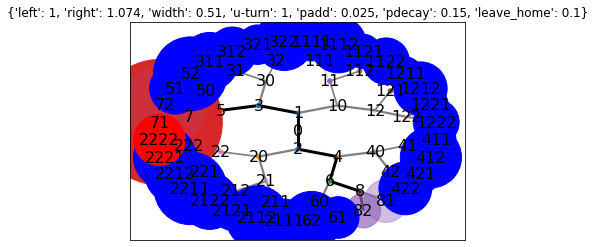

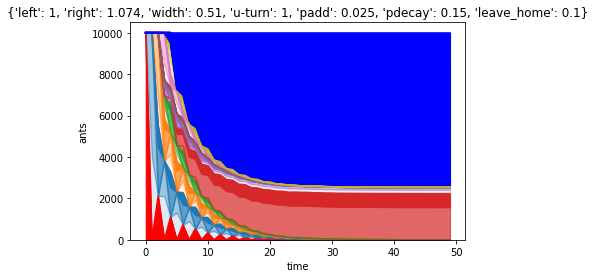

In [198]:
experiment(50,10000) # time steps, ants